# Jupyter Notebook for Iris Class
This notebook was made for the easy execution of the Iris classification code. The following code cell represents the design of our LDC class. 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os

# LDC CLASS
The following code is the LDC class. 

In [31]:
#to make a LDC, we take in a training, test an r_k list, and number of iteraterions, alpha and list of features
#make the class, d = LDC(train,test,t_l,iterations, alpha, list_of_features)
#then use w = d.train()
#could use @dataclass to not use self
class LDC:

    #initilizing the variables for the class.
    def __init__(self, train, test, t_k, iterations, alpha, list_of_features):
        '''
        function init: initilize the variables used in the class.
        param self: necessarry to object. Makes it so you can access all the variables in __init__ in the other functions
        param train: training data.
        param test: test data.
        param t_k: list with the true labels.
        param iterations: choice of number of iterations.
        param alpha: list of chosen alphas.
        param list_of_features: list of the used features.


        '''
        #attributes under
        self.train = train #np.array
        self.test = test #np.array
        self.t_k = t_k #list or np.array doesnt matter
        self.iterations = iterations #int
        self.alpha = alpha #list or np.array doesnt matter
        self.list_of_features = list_of_features #list or np.array doesnt matter
        self.class_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'] #could have this as an input to generlize class
        self.features = len(self.list_of_features) +1 #int
        self.classes = 3 #could have this as an input but didnt bother, shouldnt change
        self.weigths = np.zeros((self.classes,self.features)) #setting up weigths matrix
        self.g_k = np.zeros(self.classes) #setting up g_k array
        self.mses = np.zeros(self.iterations) #setting up array to be filled with mses
        self.confusion_matrix = np.zeros((self.classes,self.classes))#setting up confusion matrix basic
    
    #useful function to get and set variable, after class has been initilized. 
    # -----------------------------------------#   
    def set_iterations(self, iterations):
        self.iterations = iterations
    
    def set_alpha(self, alpha):
        self.alpha = alpha
    
    def set_train(self, train):
        self.train = train

    def set_test(self, test):
        self.test = test
    
    def set_train_test(self,train,test):
        self.train = train
        self.test = test
    
    def set_tk(self, tk):
        self.t_k = tk
    
    def set_list_of_features(self, list_of_features):
        self.list_of_features = list_of_features
    
    def set_num_of_classes(self,classes):
        self.classes = classes

    def get_iterations(self):
        return self.iterations
    
    def get_alpha(self):
        return self.alpha

    def get_train(self):
        return self.train

    def get_test(self):
        return self.test

    def get_train_test(self):
        return self.train, self.test

    def get_weigths(self):
        print(self.weigths)
        return self.weigths

    def get_tk(self):
        return self.t_k

    def get_list_of_features(self):
        return self.list_of_features

    def get_num_of_classes(self):
        return self.classes
    
     # -----------------------------------------#
    #just needed for resetting the cm before i test the trainset
    def reset_confusion_matrix(self):
        print('Resetting confusion matrix...')
        self.confusion_matrix = np.zeros((self.classes,self.classes))

     
    #sigmoid function activation function, eq 3.20 in compendium
    def sigmoid(self, x):
        '''
        function sigmoid: Implementation of sigmoid function.
        param self: makes it so you can access all the variables in __init__.
        param x: np.array of the instance.
        '''

        return np.array(1/(1+ np.exp(-x)))
    #another sigmoid function, not used for now
    def sigmoid2(self, x, w):
        return 1/(1+np.exp(-np.matmul(w,x)))
    #calculation the gradient_gk MSE, part of eq:3.21 compendium
    def grad_gk_mse_f(self, g_k, t_k):
        '''
        function grad_gk_mse_f: implementation of eq:3.21 compendium.
        param g_k: discirminant array.
        param t_k: true label, ex: [0,1,0] for class 2.
        '''
        grad = np.multiply((g_k-t_k),g_k)
        return grad
    #calculation the gradient_w z_k, part of eq:3.21 compendium
    def grad_W_zk_f(self, x):
        '''
        function grad_W_zk_f: #calculation the gradient_w z_k, part of eq:3.21 compendium. Same as transposing one dim array
        param x: features.
        '''
        grad = x.reshape(1,self.features)
        return grad
    #calculation the gradient_W mse, eq:3.22 compendium
    def grad_W_MSE_f(self, g_k, grad_gk_mse, grad_W_zk):
        '''
        function grad_W_MSE_f: calculation the gradient_W mse, eq:3.22 compendium.
        param g_k: discriminant array.
        param grad_gk_mse: gradient of g_kMSE.
        param grad_W_zk: gradient for Wz_k.
        '''
        return np.matmul(np.multiply(grad_gk_mse,(1-g_k)),grad_W_zk)
    #calculation MSE, eq:3.19
    def MSE_f(self, g_k,t_k):
        '''
        function MSE_f: calculation of the MSE eq:3.19
        param g_k: discriminant array.
        param t_k: true label, ex: [0,1,0] for class 2.
        '''
        return 0.5*np.matmul((g_k-t_k).T,(g_k-t_k))


    #training the model
    def train_model(self):
        print(f'Training model with {self.iterations} iterations and alpha={self.alpha}.') 
        #setting some init variables.
        self.g_k[0] = 1
        #looping through every iterations
        for i in range(self.iterations):
            #setting start values, and resetting these every iteration
            grad_W_MSE = 0
            MSE = 0
            k = 0 #this is just to know whats the target class is.
            
            for j, x in enumerate(self.train): #isnt really necessary to use enumerate, see if i should change
                if j%30==0 and j!=0:
                    k += 1
                #calculating g_k, eq:3.20 also figure 3.8/3
                self.g_k = self.sigmoid(np.matmul(self.weigths,x.reshape(self.features,1)))
                #addiing to the MSE, see function
                MSE += self.MSE_f(self.g_k,self.t_k[k])
                #calcultation this iteration of grad gk mse
                grad_gk_mse = self.grad_gk_mse_f(self.g_k,self.t_k[k])
                #calcultation this iteration of grad W zk
                grad_W_zk = self.grad_W_zk_f(x)
                #calcultation this iteration of grad W MSE
                grad_W_MSE += self.grad_W_MSE_f(self.g_k, grad_gk_mse, grad_W_zk)
            #adding the MSE to the list of mses to see the model converge
            self.mses[i] = MSE[0]
            #updating the weigths
            self.weigths = self.weigths-self.alpha*grad_W_MSE

            #printing the progress
            if(100*i /self.iterations) % 10 == 0: 
                
                print(f"\rProgress passed {100 * i / self.iterations}%", end='\n')
                
        
        print(f"\rProgress passed {(i+1)/self.iterations *100}%", end='\n')
        print('Done')
        #returning the weigths, this is not necesarry as the self does it automatically
        return self.weigths

    #function for testing the model
    def test_model(self): #or call this def fit(), to be simular as other lib.
        #just checking for some wrong inputs
        if(np.all((self.weigths==0 ))):
            print('You need to train the model first')
            return False
        if(np.all((self.confusion_matrix != 0))):
            print('You have to reset the confusion matrix first')
            print('Resetting confusion matrix')
            self.reset_confusion_matrix()

        # if test is None: #used another fix for this
        #     test = self.test
        # else:
        #     print(test)
        #     print('Testing model with training set')
        #     print('Resetting confusion matrix')

            #self.confusion_matrix = np.zeros((self.classes,self.classes))
        print(f'Testing model with {self.iterations} iterations and alpha={self.alpha}.')
        #making predictons by matmul weigths and rows in the test set, then adding the prediction and true label too confusion matrix
        for clas, test_set in enumerate(self.test):
            for row in test_set:
                prediction = np.argmax(np.matmul(self.weigths,row))
                self.confusion_matrix[clas,prediction] += 1

        return self.confusion_matrix
    #just a function that prints the cm, could have done a nice print. also calculating error rate
    def print_confusion_matrix(self):
        print(self.confusion_matrix)
        dia_sum = 0
        for i in range(len(self.confusion_matrix)):
            dia_sum += self.confusion_matrix[i, i]
        error = 1 - dia_sum / np.sum(self.confusion_matrix)
        print(f'error rate = {100 * error:.1f}%')

    #plotting the confusion matrix, not much to see here
    def plot_confusion_matrix(self, name='ok', save=False):
        dia_sum = 0
        for i in range(len(self.confusion_matrix)):
            dia_sum += self.confusion_matrix[i, i]
        error = 1 - dia_sum / np.sum(self.confusion_matrix)

        df_cm = pd.DataFrame(self.confusion_matrix, index = [i for i in self.class_names],
                  columns = [i for i in self.class_names])
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True, cmap="YlGnBu")
        plt.title(f'Confusion matrix for Iris task\n iteration: {self.iterations}, alpha: {self.alpha}.\n error rate = {100 * error:.1f}%')
        if save:
            plt.savefig(f'./figurer/confusionmatrixIris_{name}_it{self.iterations}_alpha{self.alpha}.png',dpi=200)
        else:
            plt.show()
        plt.clf()
        plt.close()
    
    #plotting the MSE, not used on less i just have one alpha
    def plot_MSE(self, save=False, log=False):
        plt.plot(self.mses)
        plt.title(f'MSE for Iris task\n iteration: {self.iterations}, alpha: {self.alpha}.')
        plt.xlabel('Iteration')
        plt.ylabel('Mean square error')
        plt.grid('on')
        if log:
            plt.xscale('log')
        if save:
            plt.savefig(f'mse_it{self.iterations}_alpha{self.alpha}.png',dpi=200)
        else:
            plt.show()
#plotting many alphas and their mse, can see which works best

# PLOTTING FUNCTIONS 


In [32]:

def plot_mses_array(arr, alphas, name='ok', save=False):
    a = 0
    alpha = r'$ \alpha $'
    for i in arr:
        plt.plot(i,label=f'{alpha}={alphas[a]}')
        a += 1

    plt.title('Mean square error for all test')
    plt.grid('on')
    plt.xlabel('Iteration')
    plt.ylabel('Mean square error')
    plt.legend(loc=1)
    if save:
        plt.savefig(f'./figurer/MSE_all_{name}.png', dpi=200)
    else:
        plt.show()
    plt.clf()
    plt.close()
 

#loading the data to a pandas dataframe. Using pandas as it has a nice visulaztion and is easy to manipulate

def load_data(path, one=True, maxVal=None, normalize=False, d=','): #change normalize to true to normalize the feature data
    data = pd.read_csv(path, sep=d) #reading csv file, and splitting with ","
    #data.columns = ['sepal_length','sepal_width','petal_length','petal_width','species']#making columnnames, for easier understanding
    #data.describe()#this gives all the information you need: count, mean, std, min, 25%, 50%,75%,max
    if one: #dont wont a column of ones when plotting
        lenght = len(data)
        #adding ones
        if lenght>60:

            data.insert(4,'Ones',np.ones(lenght),True)
        
        else:
            data['Ones'] = np.ones(lenght)
    #normalize
    if normalize:
        data = data.divide(maxVal)

    return data

#removing the feature from dataset, this can be a list
def remove_feature_dataset(data, features):
    data = data.drop(columns=features)
    print(data.head())
    return data

#this will filter out the dataframe, not used now but nice to have
def filter_dataset(data,features):
    data = data.filter(items=features)
    return data


# GLOBAL VARIABLES DECLARATION


In [33]:

#-------------global variables---------------#
classes = 3
iris_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
#features = ['sepal_length','sepal_width','petal_length','petal_width']
path = 'iris.csv'
path_setosa = 'class_1.csv'
path_versicolour = 'class_2.csv'
path_virginica = 'class_3.csv'

# DATA RETRIEVAL 


In [34]:

tot_data = load_data(path, normalize=False)
max_val = tot_data.max(numeric_only=True).max() #first max, gets max of every feature, second max gets max of the features
setosa = load_data(path_setosa,max_val) 
versicolor = load_data(path_versicolour, max_val)
virginica = load_data(path_virginica, max_val)


# ALpha Value

The following code represents the alpha value. This can be chosen according to the desired value. 

In [35]:
alphas = [0.01]


# Task 1a


In [36]:
def task1a(s=False):
    train_size = 30
    arr= []
    features = ['sepal_length','sepal_width','petal_length','petal_width']
    
    
    #----------------prepros data--------------------#
    #split_data_array = [setosa,versicolor,virginica] #not necessary

    #splitting up in test and train sets
    train = pd.concat([setosa[0:train_size],versicolor[0:train_size],virginica[0:train_size]])
    train_for_test = np.array([setosa[0:train_size],versicolor[0:train_size],virginica[0:train_size]])
    test = np.array([setosa[train_size:],versicolor[train_size:],virginica[train_size:]]) #could mb have done this for train to, 
    t_k = np.array([[[1],[0],[0]],[[0],[1],[0]],[[0],[0],[1]]]) #making array to check whats the true class is
    #just making dataframe to numpy array
    train = train.to_numpy()
    #---------------^prepros data^-------------------#

    for i in range(len(alphas)):
        print(f'Making model with 2000 iteration and an alpha of {alphas[i]} ')
        model = f'w{i}'
        model = LDC(train,test,t_k,2000,alphas[i], features)
        model.train_model()
        model.get_weigths()
        arr.append(model.mses)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='test', save=s)
        print('Testing the model with the training set')
        model.reset_confusion_matrix()
        model.set_test(train_for_test)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='train_1a', save=s)
        

    plot_mses_array(arr, alphas, name='test_1a', save=s)



# Task 1d

In [37]:
def task1d(s=False):
    train_size = 20 #still a training size of length 30, but to get the 30 last i use 20 here
    arr = [] #
    features = ['sepal_length','sepal_width','petal_length','petal_width']
   
    #----------------prepros data--------------------#
    #split_data_array = [setosa,versicolor,virginica] #not necessary

    #splitting up in test and train sets
    train = pd.concat([setosa[train_size:],versicolor[train_size:],virginica[train_size:]])
    train_for_test = np.array([setosa[train_size:],versicolor[train_size:],virginica[train_size:]])
    test = np.array([setosa[0:train_size],versicolor[0:train_size],virginica[0:train_size]]) #could mb have done this for train to, 
    t_k = np.array([[[1],[0],[0]],[[0],[1],[0]],[[0],[0],[1]]]) #making array to check whats the true class is
    #just making dataframe to numpy array
    train = train.to_numpy()
    #---------------^prepros data^-------------------#

    for i in range(len(alphas)):
        print(f'Making model with 2000 iteration and an alpha of {alphas[i]} ')
        model = f'wl{i}'
        model = LDC(train,test,t_k,2000,alphas[i], features)
        model.train_model()
        model.get_weigths()
        arr.append(model.mses)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='test', save=s)
        print('Testing the model with the training set')
        model.reset_confusion_matrix()
        model.set_test(train_for_test)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='train_1d', save=s)
        

    plot_mses_array(arr, alphas, name='test_1d', save=s)


# Task 2a


In [38]:
def task2a(s=False):
    #global setosa,versicolor,virginica
    train_size = 30
    arr = []
    features = ['sepal_length','petal_length','petal_width']
    #removing the sepal width feature because it shows most overlap
    re_feature = ['sepal_width']
    setosa1 = remove_feature_dataset(setosa,re_feature)
    versicolor1 = remove_feature_dataset(versicolor,re_feature)
    virginica1 = remove_feature_dataset(virginica,re_feature)

    #----------------prepros data--------------------#
    #split_data_array = [setosa,versicolor,virginica] #not necessary

    #splitting up in test and train sets
    train = pd.concat([setosa1[0:train_size],versicolor1[0:train_size],virginica1[0:train_size]])
    train_for_test = np.array([setosa1[0:train_size],versicolor1[0:train_size],virginica1[0:train_size]])
    test = np.array([setosa1[train_size:],versicolor1[train_size:],virginica1[train_size:]]) #could mb have done this for train to, 
    t_k = np.array([[[1],[0],[0]],[[0],[1],[0]],[[0],[0],[1]]]) #making array to check whats the true class is
    #just making dataframe to numpy array
    train = train.to_numpy()
    #---------------^prepros data^-------------------#
    for i in range(len(alphas)):
        print(f'Making model with 2000 iteration and an alpha of {alphas[i]} ')
        model = f'w2{i}'
        model = LDC(train,test,t_k,2000,alphas[i], features)
        model.train_model()
        model.get_weigths()
        arr.append(model.mses)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='test_2a', save=s)
        print('Testing the model with the training set')
        model.reset_confusion_matrix()
        model.set_test(train_for_test)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='train_2a', save=s)
        

    plot_mses_array(arr, alphas, name='test_2a', save=s)


# Task 2b - 1


In [39]:
def task2b_1(s=False):
    #also removing sepal length since it also showed alot of overlap
    #global setosa,versicolor,virginica
    train_size = 30
    arr = []
    features = ['petal_length','petal_width']
    #removing the sepal width feature because it shows most overlap
    re_feature = ['sepal_length','sepal_width']
    setosa2 = remove_feature_dataset(setosa,re_feature)
    versicolor2 = remove_feature_dataset(versicolor,re_feature)
    virginica2 = remove_feature_dataset(virginica,re_feature)

    #----------------prepros data--------------------#
    #split_data_array = [setosa,versicolor,virginica] #not necessary

    #splitting up in test and train sets
    train = pd.concat([setosa2[0:train_size],versicolor2[0:train_size],virginica2[0:train_size]])
    train_for_test = np.array([setosa2[0:train_size],versicolor2[0:train_size],virginica2[0:train_size]])
    test = np.array([setosa2[train_size:],versicolor2[train_size:],virginica2[train_size:]]) #could mb have done this for train to, 
    t_k = np.array([[[1],[0],[0]],[[0],[1],[0]],[[0],[0],[1]]]) #making array to check whats the true class is
    #just making dataframe to numpy array
    train = train.to_numpy()
    #---------------^prepros data^-------------------#
    for i in range(len(alphas)):
        print(f'Making model with 2000 iteration and an alpha of {alphas[i]} ')
        model = f'w2{i}'
        model = LDC(train,test,t_k,2000,alphas[i], features)
        model.train_model()
        arr.append(model.mses)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='test_2b1', save=s)
        print('Testing the model with the training set')
        model.reset_confusion_matrix()
        model.set_test(train_for_test)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='train_2b1', save=s)
        

    plot_mses_array(arr, alphas, name='test_2b1', save=s)


# Task 2b-2

In [40]:
def task2b_2(s=False):
    #also removing petal width
    #global setosa,versicolor,virginica
    train_size = 30
    arr = []
    features = ['petal_length']
    #removing the sepal width feature because it shows most overlap
    re_feature = ['sepal_length','sepal_width','petal_width']
    setosa3 = remove_feature_dataset(setosa,re_feature)
    versicolor3 = remove_feature_dataset(versicolor,re_feature)
    virginica3 = remove_feature_dataset(virginica,re_feature)

    #----------------prepros data--------------------#
    #split_data_array = [setosa,versicolor,virginica] #not necessary

    #splitting up in test and train sets
    train = pd.concat([setosa3[0:train_size],versicolor3[0:train_size],virginica3[0:train_size]])
    train_for_test = np.array([setosa3[0:train_size],versicolor3[0:train_size],virginica3[0:train_size]])
    test = np.array([setosa3[train_size:],versicolor3[train_size:],virginica3[train_size:]]) #could mb have done this for train to, 
    t_k = np.array([[[1],[0],[0]],[[0],[1],[0]],[[0],[0],[1]]]) #making array to check whats the true class is
    #just making dataframe to numpy array
    train = train.to_numpy()
    #---------------^prepros data^-------------------#
    for i in range(len(alphas)):
        print(f'Making model with 2000 iteration and an alpha of {alphas[i]} ')
        model = f'w3{i}'
        model = LDC(train,test,t_k,2000,alphas[i], features)
        model.train_model()
        arr.append(model.mses)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='test_2b2', save=s)
        print('Testing the model with the training set')
        model.reset_confusion_matrix()
        model.set_test(train_for_test)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='train_2b2', save=s)
        

    plot_mses_array(arr, alphas, name='test_2b2', save=s)


# Task 2b-2-1


In [41]:
def task2b_2_1(s=False):
    #Testing with removing petal length
    #global setosa,versicolor,virginica, not nice solution

    train_size = 30
    arr = []
    features = ['petal_width']
    #removing the sepal width feature because it shows most overlap
    re_feature = ['sepal_length','sepal_width','petal_length']
    setosa4 = remove_feature_dataset(setosa,re_feature)
    versicolor4 = remove_feature_dataset(versicolor,re_feature)
    virginica4 = remove_feature_dataset(virginica,re_feature)

    #----------------prepros data--------------------#
    #split_data_array = [setosa,versicolor,virginica] #not necessary

    #splitting up in test and train sets
    train = pd.concat([setosa4[0:train_size],versicolor4[0:train_size],virginica4[0:train_size]])
    train_for_test = np.array([setosa4[0:train_size],versicolor4[0:train_size],virginica4[0:train_size]])
    test = np.array([setosa4[train_size:],versicolor4[train_size:],virginica4[train_size:]]) #could mb have done this for train to, 
    t_k = np.array([[[1],[0],[0]],[[0],[1],[0]],[[0],[0],[1]]]) #making array to check whats the true class is
    #just making dataframe to numpy array
    train = train.to_numpy()
    #---------------^prepros data^-------------------#
    for i in range(len(alphas)):
        print(f'Making model with 2000 iteration and an alpha of {alphas[i]} ')
        model = f'w4{i}'
        model = LDC(train,test,t_k,2000,alphas[i], features)
        model.train_model()
        arr.append(model.mses)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='test_2b2_1', save=s)
        print('Testing the model with the training set')
        model.reset_confusion_matrix()
        model.set_test(train_for_test)
        model.test_model()
        model.print_confusion_matrix()
        model.plot_confusion_matrix(name='train_2b2_1', save=s)
        

    plot_mses_array(arr, alphas, name='test_2b2_1', save=s)


# RUN FROM HERE
Run all cells from the below python cell in order to initialise the Jupyter notebook. After that, one can then simply run any cell below in any order. 

Making model with 2000 iteration and an alpha of 0.01 
Training model with 2000 iterations and alpha=0.01.
Progress passed 0.0%
Progress passed 10.0%
Progress passed 20.0%
Progress passed 30.0%
Progress passed 40.0%
Progress passed 50.0%
Progress passed 60.0%
Progress passed 70.0%
Progress passed 80.0%
Progress passed 90.0%
Progress passed 100.0%
Done
[[ 0.42824382  1.67999442 -2.50046027 -1.15753733  0.30351656]
 [ 1.47200709 -2.91796407 -0.19449539 -1.16621896  1.59321638]
 [-2.95381208 -2.49268087  4.31438566  3.76207286 -1.88782971]]
Testing model with 2000 iterations and alpha=0.01.
[[20.  0.  0.]
 [ 0. 18.  2.]
 [ 0.  0. 20.]]
error rate = 3.3%


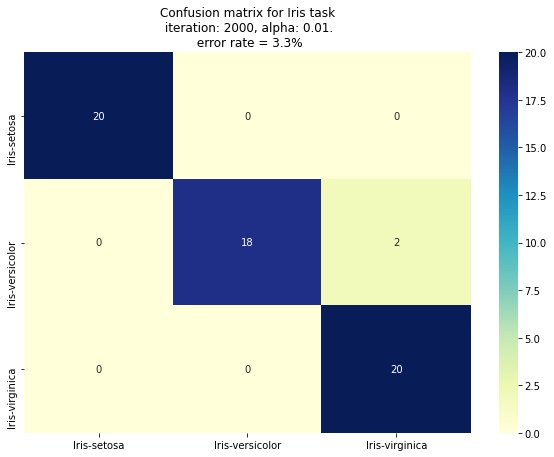

Testing the model with the training set
Resetting confusion matrix...
Testing model with 2000 iterations and alpha=0.01.
[[30.  0.  0.]
 [ 0. 28.  2.]
 [ 0.  1. 29.]]
error rate = 3.3%


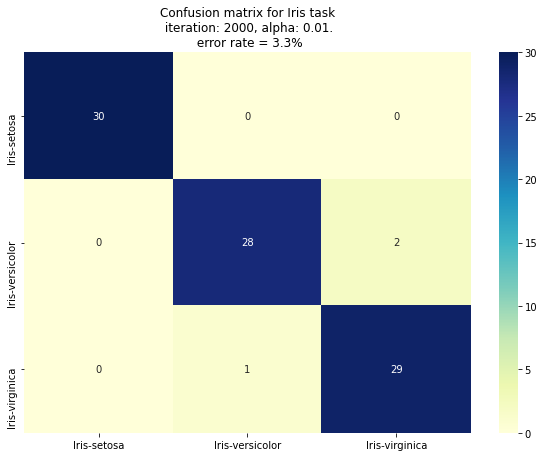

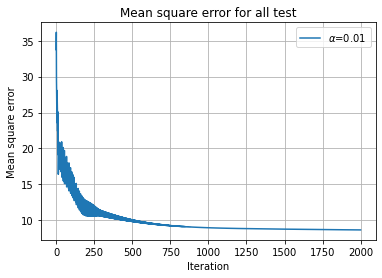

In [42]:
#Runtime code. Run all cells above, then run any cell below.
task1a()


In [ ]:
task1d()

In [ ]:
task2a()

In [ ]:
task2b_1()

In [ ]:
task2b_2()

In [ ]:
task2b_2_1()